Current libraries that can load tdm/tdx:
  - TDMtermite: https://github.com/RecordEvolution/TDMtermite
  - tdm-loader: https://pypi.org/project/tdm-loader/
  - Perfcode implementation

Test files and code found on NI site:
https://forums.ni.com/t5/Example-Code/Reading-TDM-TDMS-Files-with-The-MathWorks-Inc-MATLAB-Software/ta-p/3996480

NI Docs on tdm file format:
https://www.ni.com/docs/en-US/bundle/diadem/page/tdmdatamodel/tdmdatamodel/tdm_fileformat.htm

Unpacking tdx data with python struct lib:
https://docs.python.org/3/library/struct.html

lxml documentation:
https://lxml.de/index.html

In [1]:
import pandas as pd
import numpy as np

from struct import unpack_from
from pathlib import Path
from lxml import etree

In [2]:
class TdmTdx:

    DATA_TYPES = {
        # Used for unpacking tdx data
        'eInt16Usi': 'h',
        'eInt32Usi': 'l',
        'eUInt8Usi': 'B',  # not entirely sure this is right
        'eUInt16Usi': 'H',
        'eUInt32Usi': 'L',
        'eFloat32Usi': 'f',
        'eFloat64Usi': 'd',
        'eStringUsi': 'c',  # NO IDEA WHAT THIS IS
        # Used for finding value_sequence_element
        # tdm_channel/datatype.text: value_sequence.tag
        'DT_SHORT': 'short_sequence',
        'DT_LONG': 'long_sequence',
        'DT_BYTE': 'byte_sequence',
        'DT_FLOAT': 'float_sequence',
        'DT_DOUBLE': 'double_sequence',
        'DT_STRING': 'string_sequence'
    }

    def __init__(self, tdm_path, tdx_path=None):
        # TDM
        self.tdm = etree.parse(tdm_path)

        # TDX
        if not tdx_path:
            tdx_path = Path(tdm_path).parent.joinpath(
                self.tdm.find('{*}include/file').attrib.get('url')
            )
        with open(tdx_path, 'rb') as file:
            self.tdx = file.read()

        # mapping of channel names to the tdm metadata tree element
        self._channels = {
            element.find('name').text: element
            for element in self.tdm.find('{*}data').iterchildren(tag='tdm_channel')
        }

        # list of all the channels in file
        self.channel_list = self._channels.keys()

        # byteorder of tdx file
        self.byteorder = self.tdm.find('{*}include/file').attrib.get('byteOrder')
        if self.byteorder.lower() == 'littleendian':
            self.byteorder_sym = '<'
        elif self.byteorder.lower() == 'bigendian':
            self.byteorder_sym = '>'
        else:
            raise ValueError(f'Unknown byteorder of {self.byteorder}')

    @staticmethod
    def xpointer_ids(xp_text):
        return [
            id_.removeprefix('id("').removesuffix('")')
            for id_ in
            xp_text.removeprefix('#xpointer(').removesuffix(')').split(' ')
        ]

    def xpointer_elements(self, ids, block, tag):
        return [
            element for element
            in self.tdm.find(f'{{*}}{block}').iterchildren(tag=tag)
            for id_ in ids
            if element.attrib.get('id') == id_
        ]

    def read_tdx_block(self, length, offset, valuetype):
        return unpack_from(
            f'{self.byteorder_sym}{length}{TdmTdx.DATA_TYPES[valuetype]}',
            self.tdx,
            offset=int(offset)
        )

    def get_chan(self, name):
        tdm_channel_element = self._channels.get(name)
        if tdm_channel_element is not None:
            # REMEMBER from NI site:
            # Each channel only has one Submatrix and one LocalColumn in the TDM file
            local_column_element = self.xpointer_elements(
                self.xpointer_ids(tdm_channel_element.find('local_columns').text),
                'data',
                'localcolumn'
            )[0]
            value_sequence_element = self.xpointer_elements(
                self.xpointer_ids(local_column_element.find('values').text),
                'data',
                TdmTdx.DATA_TYPES[tdm_channel_element.find('datatype').text]
            )[0]
            block_id = value_sequence_element.find('values').attrib.get('external')
            block_element = self.xpointer_elements([block_id], 'include/file', '*')[0]
            if block_element.tag == 'block':
                return self.read_tdx_block(
                    block_element.attrib['length'],
                    block_element.attrib['byteOffset'],
                    block_element.attrib['valueType']
                )
            else:  #block_bm
                pass
            

In [4]:
%%timeit # 920 microseconds
tdmx = TdmTdx('SineData.tdm')
for chan in tdmx.channel_list:
    data = tdmx.get_chan(chan)

920 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
index = np.arange(1000)
df = pd.DataFrame(
    data={'index':index},
    index=index
)

In [8]:
tdmx = TdmTdx('SineData.tdm')
for chan in tdmx.channel_list:
    df[chan] = tdmx.get_chan(chan)

<AxesSubplot:>

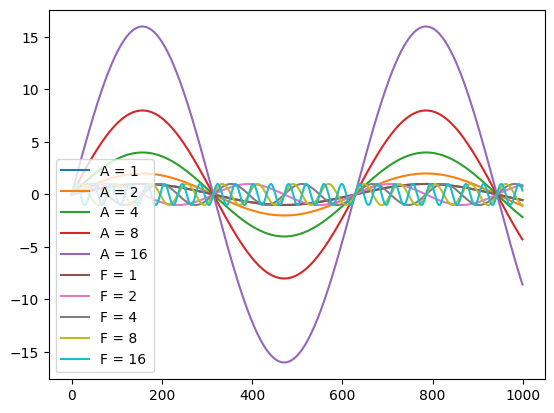

In [9]:
df.drop(columns='index').plot()